# Rainfall across the Australian wheatbelt

The Australian Bureau of Agricultural and Resource Economics and Sciences (ABARES)
defines a set of Australian broadacre zones and regions.

The last four very dry years across the "wheat-sheep" region
line up really well with the last four times Australia had to import grain
(1994-95, 2002-03, 2006-07, 2019-20; see
[ABC](https://www.abc.net.au/news/rural/2019-05-15/australia-approves-grain-imports/11113320),
[Guardian](https://www.theguardian.com/australia-news/2019/may/15/australia-to-import-wheat-for-first-time-in-12-years-as-drought-eats-into-grain-production)).

In [1]:
wheat_import_years = [1994, 2002, 2006, 2019]

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
from IPython.display import Image
import cftime

from unseen import fileio
from unseen import time_utils

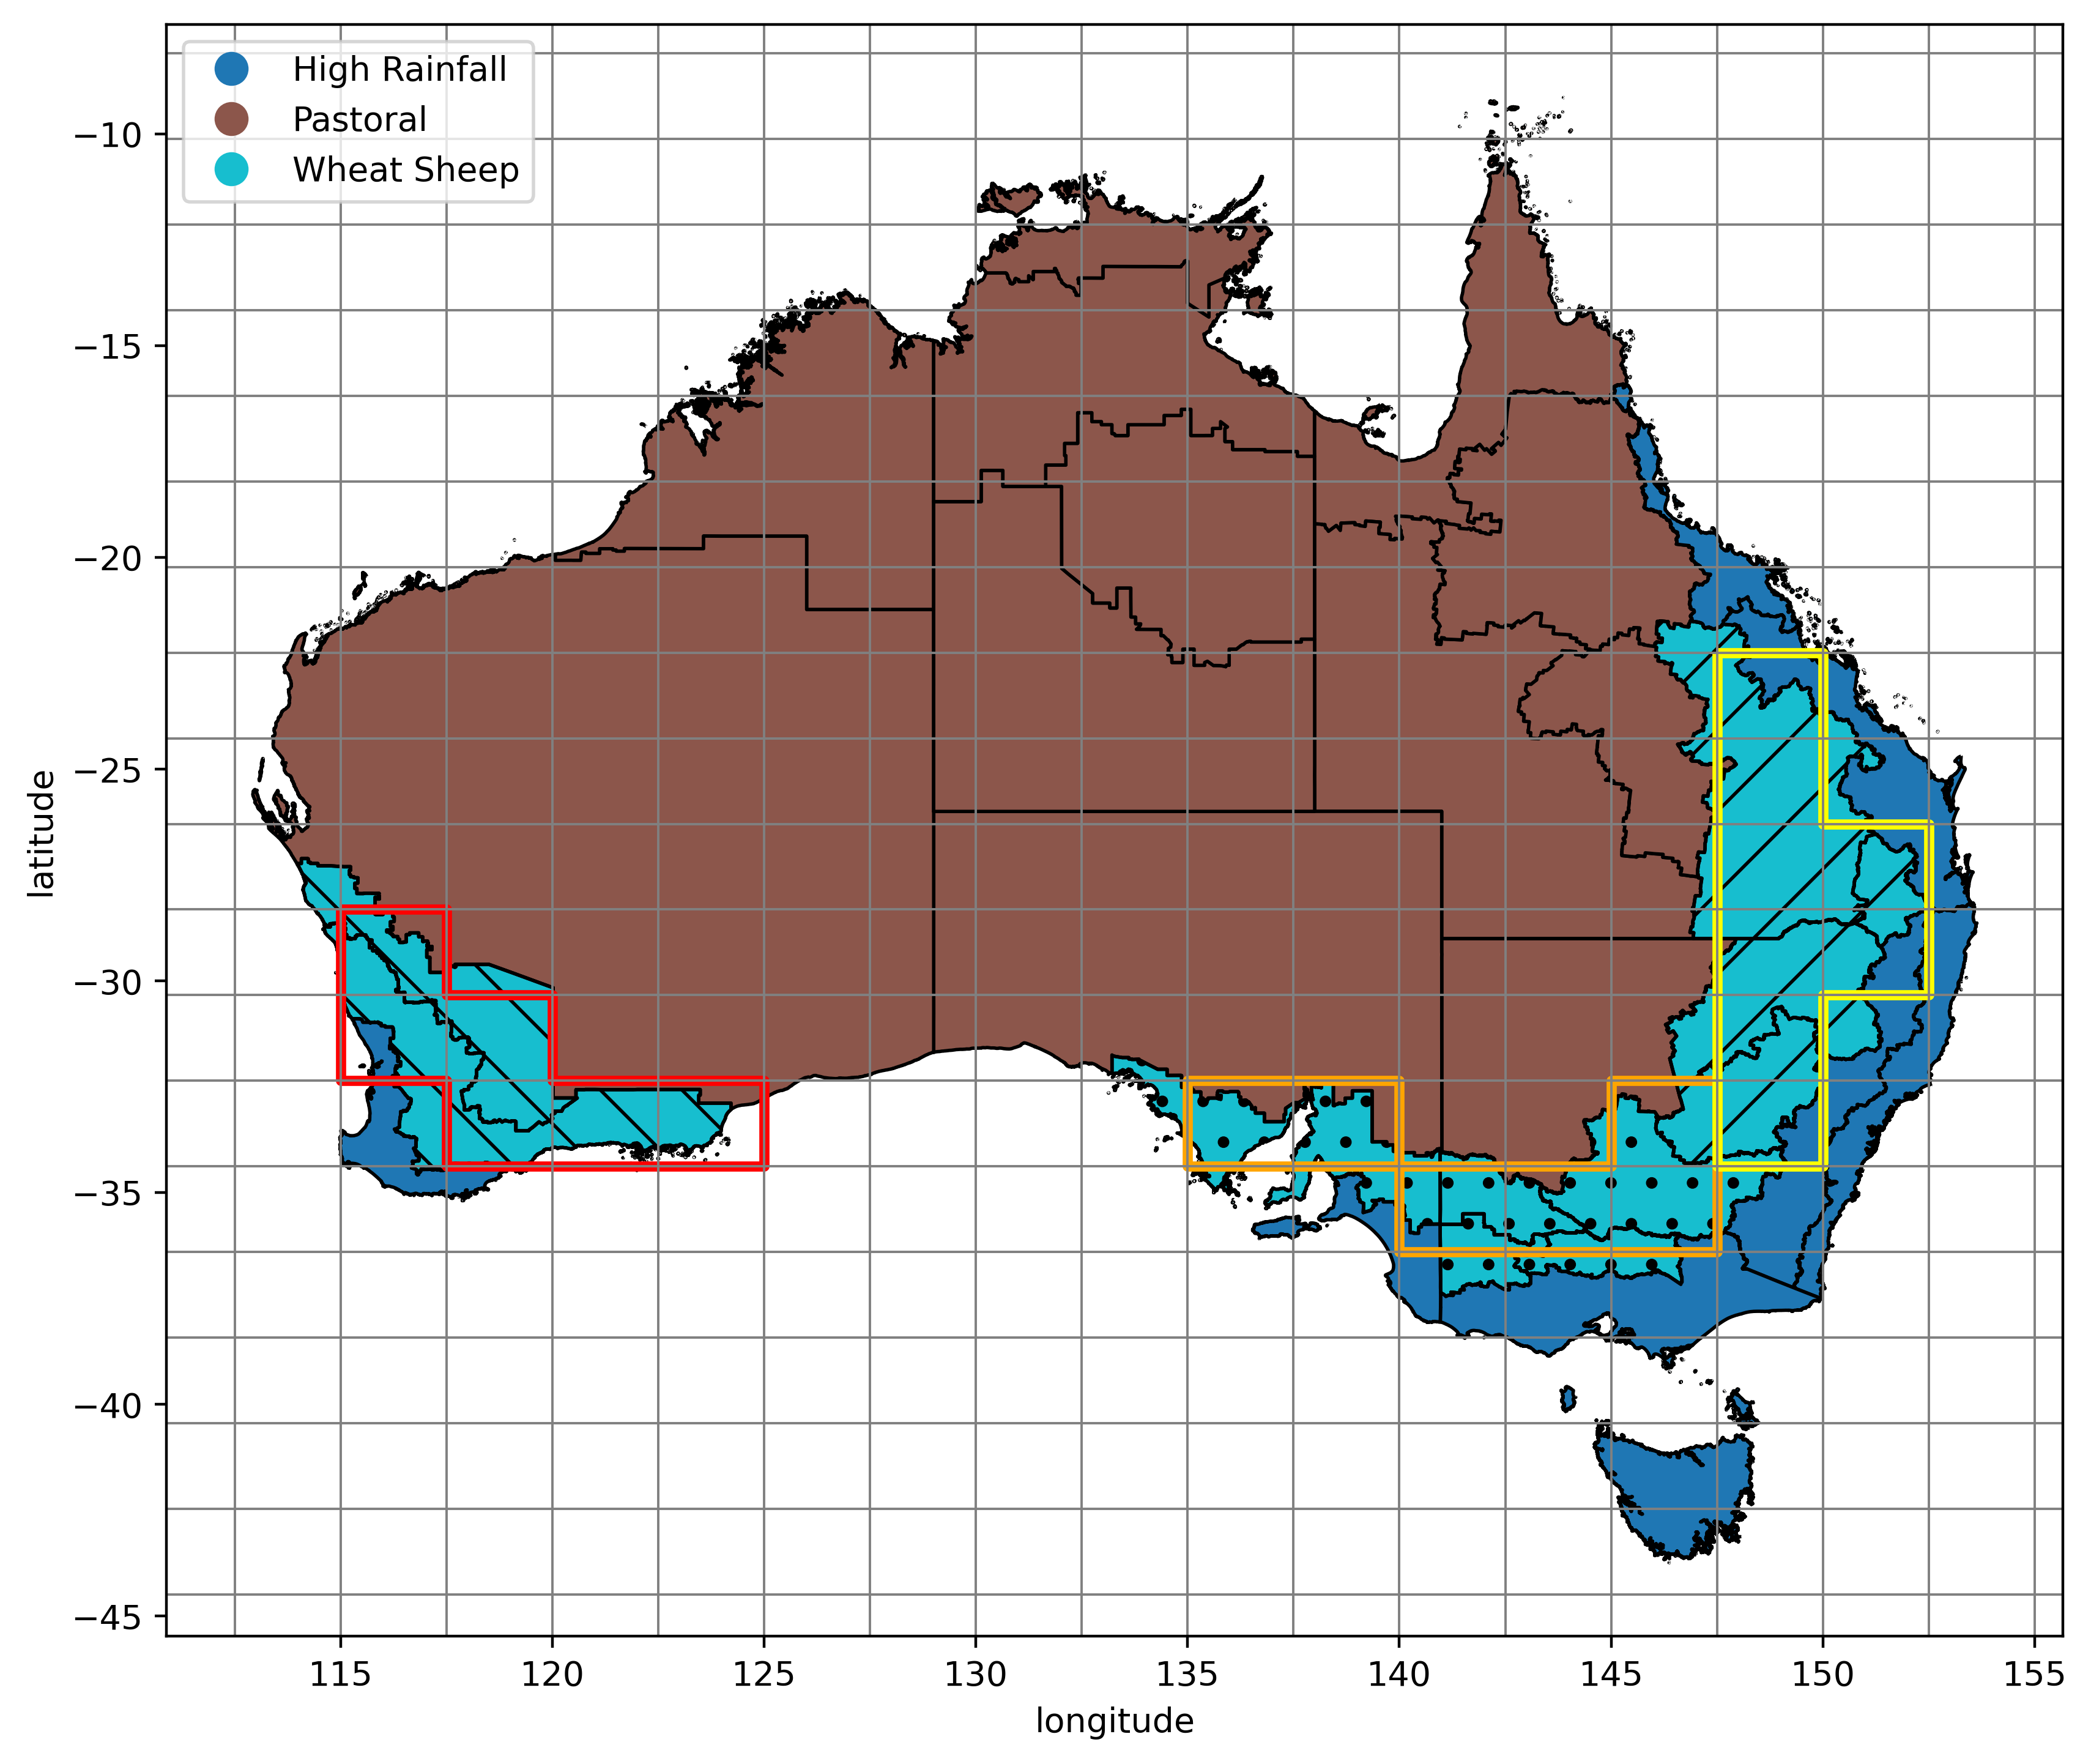

In [3]:
Image(filename='/g/data/xv83/dbi599/ag/figures/ag_regions.png')

In [4]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [5]:
# Parameters
agcd_file = (
    "/g/data/xv83/dbi599/ag/data/pr_agcd_1900-2019_A-DEC_wheat-sheep-mean.zarr.zip"
)
cafe_file = "/g/data/xv83/dbi599/ag/data/pr_cafe-c5-d60-pX-f6_19950501-20201101_A-DEC_wheat-sheep-mean.zarr.zip"
cafe_bc_file = "/g/data/xv83/dbi599/ag/data/pr_cafe-c5-d60-pX-f6_19950501-20191101_A-DEC_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
fidelity_file = "/g/data/xv83/dbi599/ag/data/ks-test_pr_cafe-c5-d60-pX-f6_19950501-20191101_A-DEC_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/ag/figures/independence-test_pr_cafe-c5-d60-pX-f6_19950501-20191101_A-DEC_wheat-sheep-south-east-mean_bias-corrected-agcd-additive.png"
region = "south-east"


In [6]:
# Required parameters
assert 'region' in locals(), "Must provide an AGCD data file (papermill option -p region [all south-west south-east or north-east])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(cafe_file), "Must provide an CAFE data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(cafe_bc_file), "Must provide an CAFE bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(fidelity_file), "Must provide an fidelity test file (papermill option -p fidelity_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [7]:
agcd_ds = fileio.open_dataset(agcd_file)

In [8]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 4, time: 121)
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
  * time     (time) object 1900-12-31 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [9]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df[region] = agcd_ds['pr'].sel(region=region).values

In [10]:
mean_rainfall = agcd_df[region].mean()
print(mean_rainfall)

373.25862619617305


In [11]:
years_list = list(years)
nyears = len(years_list)
colors = ['tab:blue'] * nyears
for year in wheat_import_years:
    index = years_list.index(year)
    colors[index] = 'tab:red'

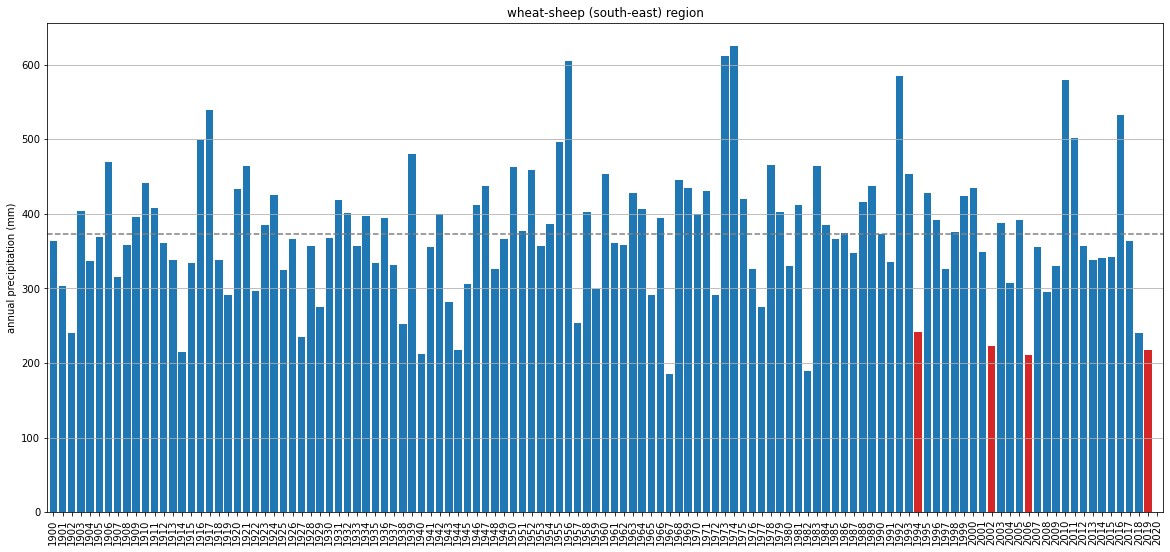

In [12]:
agcd_df[region].plot.bar(figsize=[20, 9], width=0.8, color=colors)
plt.axhline(mean_rainfall, color='0.5', linestyle='--')
plt.ylabel('annual precipitation (mm)')
plt.title(f'wheat-sheep ({region}) region')
plt.grid(axis='y')
plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [13]:
ranked_years = agcd_df[region].sort_values()
ranked_years.head(n=10)

1967    185.395802
1982    189.494827
2006    211.394993
1940    211.873695
1914    214.681797
2019    217.035879
1944    217.815183
2002    222.743198
1927    235.092914
2018    239.781494
Name: south-east, dtype: float64

In [14]:
def year_in_context(ranked_years_df, year):
    """Put a given year in context"""
    
    nyears = len(ranked_years_df)
    rank = ranked_years_df.index.get_loc(year) + 1
    percentile = (rank / nyears) * 100
    return_period = nyears / rank
    
    print(f'# {year} statistics:')
    print(f'{rank} in {nyears} year event')
    print(f'{percentile:.1f}% percentile')
    print(f'{return_period:.0f} year return period')
    print(' ')

In [15]:
for year in wheat_import_years:
    year_in_context(ranked_years, year)

# 1994 statistics:
12 in 121 year event
9.9% percentile
10 year return period
 
# 2002 statistics:
8 in 121 year event
6.6% percentile
15 year return period
 
# 2006 statistics:
3 in 121 year event
2.5% percentile
40 year return period
 
# 2019 statistics:
6 in 121 year event
5.0% percentile
20 year return period
 


In [16]:
all_regions = ['all', 'south-west', 'south-east', 'north-east']
for comparison_region in all_regions:
    if not region == comparison_region:
        corr = xr.corr(agcd_ds['pr'].sel(region=region),
                       agcd_ds['pr'].sel(region=comparison_region),
                       dim='time').values
        print(f'{region} vs {comparison_region}: {corr}')

south-east vs all: 0.8608693444278999


south-east vs south-west: 0.4451801131569965


south-east vs north-east: 0.6669218008084937


## Model ensemble

In [17]:
cafe_ds = fileio.open_dataset(cafe_file)
cafe_bc_ds = fileio.open_dataset(cafe_bc_file)

In [18]:
cafe_bc_ds['pr'].attrs['units']

'mm d-1'

### Bias correction and fidelity testing

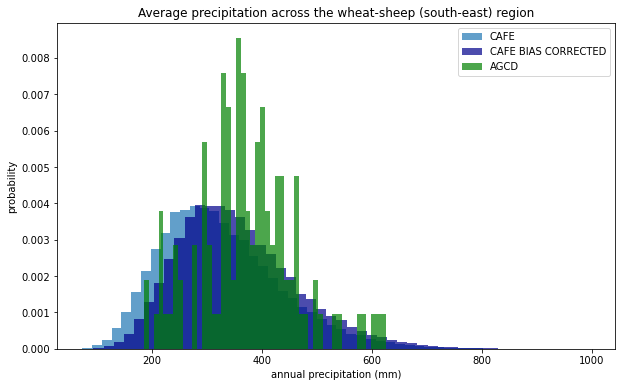

In [19]:
fig = plt.figure(figsize=[10, 6])
cafe_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE', alpha=0.7)
cafe_bc_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7)
agcd_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the wheat-sheep ({region}) region')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_histogram_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [20]:
fidelity_ds = xr.open_zarr(fidelity_file)

In [21]:
fidelity_ds.sel(region=region)['pval'].values

array([0.63553782, 0.81046472, 0.70368098, 0.62328831, 0.74261712,
       0.71450005, 0.7778771 , 0.71989043, 0.74791336])

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Independence testing

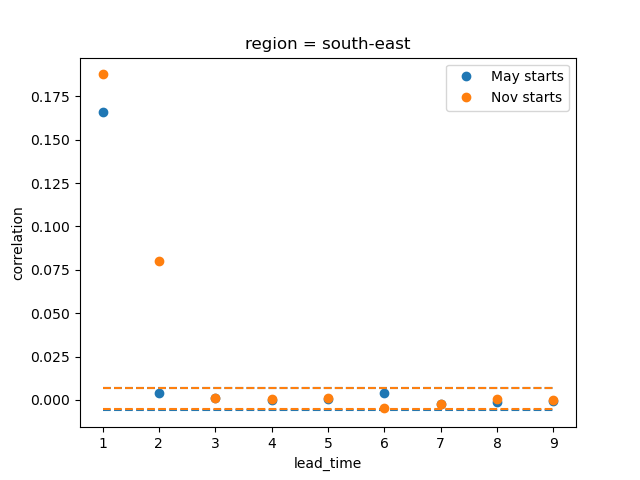

In [22]:
Image(filename=independence_plot)

### Exceedance curves

In [23]:
cafe_bc_ds_stacked = cafe_bc_ds.sel(region=region, lead_time=slice(3, None))['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [24]:
cafe_bc_ds_stacked.shape

(39936,)

In [25]:
cafe_bc_ds_stacked = time_utils.select_time_period(cafe_bc_ds_stacked, ['1995-01-01', '2019-12-31'])

In [26]:
cafe_bc_ds_stacked = cafe_bc_ds_stacked.dropna(dim='sample')

In [27]:
cafe_bc_ds_stacked.shape

(25536,)

In [28]:
def calc_exceedance(ds_stacked):
    """Calculate exceedance"""
    
    data = ds_stacked.compute()
    sorted_data = np.sort(data, axis=None)
    exceedance = 1.-np.arange(1.,len(data) + 1.)/len(data)
    
    return sorted_data, exceedance

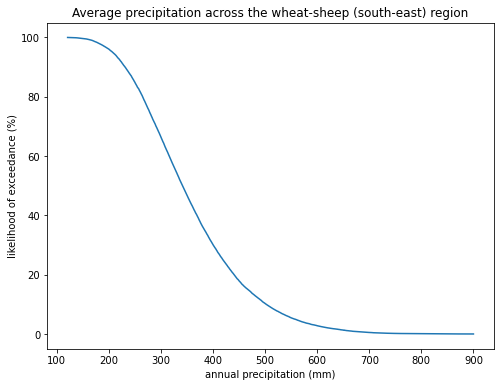

In [29]:
sorted_data, exceedance = calc_exceedance(cafe_bc_ds_stacked)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, exceedance * 100)
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
plt.show()

In [30]:
def event_in_context(data, threshold, year, direction):
    """Put an event in context
    
    Args:
      data (np.ndarray)
      threshold (float) : event threshold
      year (int) : year that the event occured in the observations
      direction (str) : 'less' or 'greater' than
    """

    n_population = len(data)
    if direction == 'less':
        n_events = np.sum(data < threshold)
    elif direction == 'greater':
        n_events = np.sum(data > threshold)
    else:
        raise ValueError("""direction must be 'less' or 'greater'""")
    percentile = (n_events / n_population) * 100
    return_period = 1 / (percentile / 100)
    
    print(f'# {year} ({threshold:.1f}mm) statistics:')
    print(f'{n_events} in {n_population} year event')
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period')
    print(' ')

#### Full 1990-2019 time period

# 1994 (241.4mm) statistics:
3197 in 25536 year event
12.52% percentile
8 year return period
 
# 2002 (222.7mm) statistics:
2030 in 25536 year event
7.95% percentile
13 year return period
 
# 2006 (211.4mm) statistics:
1433 in 25536 year event
5.61% percentile
18 year return period
 
# 2019 (217.0mm) statistics:
1730 in 25536 year event
6.77% percentile
15 year return period
 


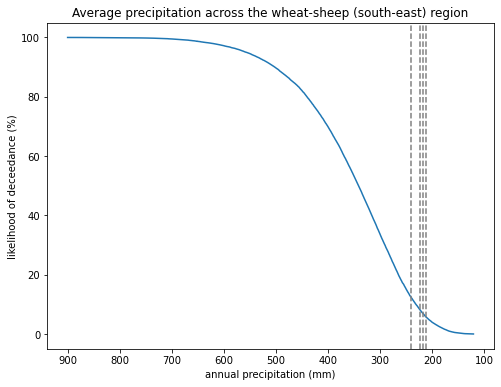

In [31]:
for year in wheat_import_years:
    event_in_context(sorted_data, ranked_years[year], year, 'less')

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, 100 - (exceedance * 100))
ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')

for year in wheat_import_years:
    ax.axvline(ranked_years[year], color='0.5', linestyle='--')

plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_deceedence_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)

#### By decade

2004-2007


# 1994 (241.4mm) statistics:
677 in 5376 year event
12.59% percentile
8 year return period
 


# 2002 (222.7mm) statistics:
429 in 5376 year event
7.98% percentile
13 year return period
 


# 2006 (211.4mm) statistics:
304 in 5376 year event
5.65% percentile
18 year return period
 


# 2019 (217.0mm) statistics:
366 in 5376 year event
6.81% percentile
15 year return period
 


2008-2011


# 1994 (241.4mm) statistics:
649 in 5376 year event
12.07% percentile
8 year return period
 


# 2002 (222.7mm) statistics:
435 in 5376 year event
8.09% percentile
12 year return period
 


# 2006 (211.4mm) statistics:
304 in 5376 year event
5.65% percentile
18 year return period
 


# 2019 (217.0mm) statistics:
382 in 5376 year event
7.11% percentile
14 year return period
 


2012-2015


# 1994 (241.4mm) statistics:
709 in 5376 year event
13.19% percentile
8 year return period
 


# 2002 (222.7mm) statistics:
428 in 5376 year event
7.96% percentile
13 year return period
 


# 2006 (211.4mm) statistics:
308 in 5376 year event
5.73% percentile
17 year return period
 


# 2019 (217.0mm) statistics:
363 in 5376 year event
6.75% percentile
15 year return period
 


2016-2019


# 1994 (241.4mm) statistics:
711 in 5376 year event
13.23% percentile
8 year return period
 


# 2002 (222.7mm) statistics:
470 in 5376 year event
8.74% percentile
11 year return period
 


# 2006 (211.4mm) statistics:
346 in 5376 year event
6.44% percentile
16 year return period
 


# 2019 (217.0mm) statistics:
400 in 5376 year event
7.44% percentile
13 year return period
 


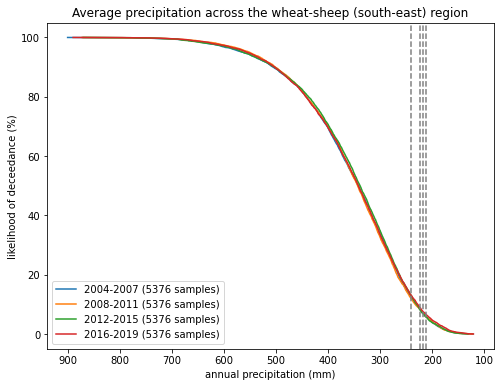

In [32]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

for start_year in [2004, 2008, 2012, 2016]:
    end_year = start_year + 3
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    ds_selection = time_utils.select_time_period(cafe_bc_ds_stacked, [start_date, end_date])
    ds_selection = ds_selection.dropna('sample')
    sorted_data, exceedance = calc_exceedance(ds_selection)
    n_years = len(sorted_data)
    label = f'{start_year}-{end_year} ({n_years} samples)'
    ax.plot(sorted_data, 100 - (exceedance * 100), label=label)
    
    print(f'{start_year}-{end_year}')
    for year in wheat_import_years:
        event_in_context(ds_selection.values, ranked_years[year], year, 'less')

ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
ax.legend()
for year in wheat_import_years:
    ax.axvline(ranked_years[year], color='0.5', linestyle='--')

plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_deceedence-by-pentad_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)